# Volatility Forecasting using Econometric and Machine Learning Models  
### Notebook 02: GARCH Volatility Modeling

**Objective**  
This notebook estimates a GARCH(1,1) volatility model using heavy-tailed innovations to:
- Capture volatility clustering
- Model time-varying conditional variance
- Generate volatility forecasts for risk evaluation

The notebook is fully independent and reloads all required data.


In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 19.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arch import arch_model

plt.style.use("seaborn-v0_8")


In [5]:
returns = pd.read_csv("returns.csv", index_col=0, parse_dates=True)
#returns = returns.squeeze()  # convert to Series

returns.head()


,log_return
Date,
2010-01-05,0.008696
2010-01-06,0.000739
2010-01-07,-0.003547
2010-01-08,-0.003493
2010-01-11,0.000886


## Why GARCH?

Financial returns exhibit:
- Volatility clustering
- Time-varying conditional variance
- Persistence of shocks

GARCH models explicitly capture these features by allowing current volatility to depend on:
- Past squared returns
- Past volatility


## GARCH(1,1) Specification

Mean equation:
\[
r_t = \mu + \epsilon_t
\]

Variance equation:
\[
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
\]

Where:
- \( \alpha \) measures shock sensitivity
- \( \beta \) measures volatility persistence
- \( \alpha + \beta \approx 1 \) indicates long memory

We use **Student-t innovations** to account for fat tails.


## Estimation Choices

- Model: GARCH(1,1)
- Mean: Constant
- Distribution: Student-t
- Estimation: Maximum Likelihood

Student-t errors are chosen due to strong empirical evidence of excess kurtosis in returns.


In [6]:
garch = arch_model(
    returns * 100,          # scale returns for numerical stability
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="t"
)

garch_res = garch.fit(disp="off")

garch_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5162.82
Distribution:      Standardized Student's t   AIC:                           10335.6
Method:                  Maximum Likelihood   BIC:                           10367.0
                                              No. Observations:                 3925
Date:                      Sat, Dec 27 2025   Df Residuals:                     3924
Time:                              06:53:51   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0711  1.306e-02      5.444  5.212e-08 [4.550e-02,9.669e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0190  4.605e-03      4.121  3.771e-05 [9.951e-03,2.800e-02]
alpha[1]       0.0733  9.948e-03      7.367  1.746e-13 [5.379e-02,9.278e-02]
beta[1]        0.9078  1.188e-02     76.450      0.000     [  0.885,  0.931]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             7.2498      0.808      8.978  2.767e-19 [  5.667,  8.833]
========================================================================

Covariance estimator: robust
"""

In [7]:
params = garch_res.params

alpha = params["alpha[1]"]
beta = params["beta[1]"]
persistence = alpha + beta

pd.Series({
    "Alpha (Shock Sensitivity)": alpha,
    "Beta (Persistence)": beta,
    "Alpha + Beta": persistence
})


,0
Alpha (Shock Sensitivity),0.073283
Beta (Persistence),0.907850
Alpha + Beta,0.981133


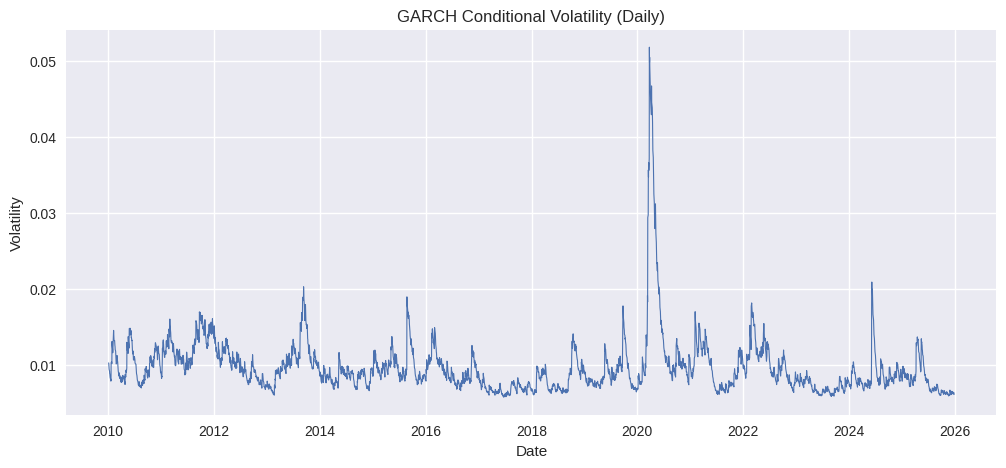

In [8]:
cond_vol = garch_res.conditional_volatility / 100

plt.figure(figsize=(12,5))
plt.plot(cond_vol, linewidth=0.8)
plt.title("GARCH Conditional Volatility (Daily)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [9]:
garch_res

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5162.82
Distribution:      Standardized Student's t   AIC:                           10335.6
Method:                  Maximum Likelihood   BIC:                           10367.0
                                              No. Observations:                 3925
Date:                      Sat, Dec 27 2025   Df Residuals:                     3924
Time:                              06:53:51   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [11]:
forecast = garch_res.forecast(horizon=1)
forecast

In [12]:
forecast = garch_res.forecast(horizon=1)
garch_forecast_var = forecast.variance.iloc[-1, 0] / (100**2)
garch_forecast_vol = np.sqrt(garch_forecast_var)

garch_forecast_vol

np.float64(0.006117962052593503)

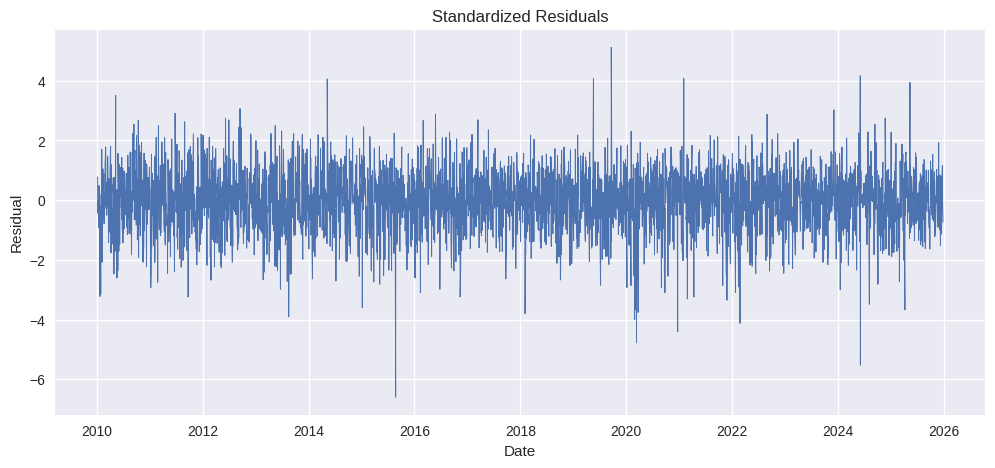

In [13]:
std_resid = garch_res.std_resid

plt.figure(figsize=(12,5))
plt.plot(std_resid, linewidth=0.7)
plt.title("Standardized Residuals")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()


In [14]:
cond_vol.to_csv("garch_conditional_volatility.csv")
pd.Series(garch_forecast_vol, name="garch_1day_vol_forecast").to_csv("garch_1day_forecast.csv")


## Summary

In this notebook, we:
- Estimated a GARCH(1,1) model with Student-t innovations
- Observed high volatility persistence
- Extracted conditional volatility estimates
- Generated 1-day-ahead volatility forecasts

The next notebook will use machine learning models to forecast volatility and compare them against the GARCH benchmark.
